# Librarias

In [1]:
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 8.9 MB 3.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 3.5 MB 4.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 2.5 MB 4.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 722 kB 4.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/c

In [2]:
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F

import time

# Colab-drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataframe

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Teoría de grafos/urban/UrbanSound8K.csv")
df

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


In [5]:
df = df[(df.end - df.start) >= 1]
df.reset_index(drop=True, inplace=True)
df

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
1,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
2,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
3,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
4,100263-2-0-143.wav,100263,71.500000,75.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8271,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8272,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8273,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8274,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


# Datos

Los datos usados son del dataset urbansound8k y sus audios fueron caracterizados con el modelo preentrenado PANNs para luego guardar dichas caracteristicas y etiquetas en un archivo con extencion .h5py

In [6]:
import h5py

In [7]:
TF = h5py.File('/content/drive/MyDrive/Teoría de grafos/urban/Datos/TF_PANNs_8276.hdf5', 'r')

In [8]:
X = TF['features']
Y = TF['labels']

In [9]:
X_tensor = torch.tensor(X)
Y_tensor = torch.tensor(Y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  """Entry point for launching an IPython kernel.


In [10]:
X_tensor.shape

torch.Size([8276, 2048])

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Creacion de grafos

In [12]:
from torch_geometric.data import Data
from torch_geometric.nn import knn_graph

In [13]:
def CrossVal(df, idxtest, idxval):
    df.reset_index(drop=True, inplace=True)
    df2 = df.copy()
    
    Idx_test = df.index[df.fold == idxtest]

    df2.drop(Idx_test, inplace=True)

    Idx_val = df.index[df.fold == idxval]

    df2.drop(Idx_val, inplace=True)
    
    Idx_train = df2.index
    
    return Idx_train, Idx_test, Idx_val

In [14]:
def graph(X_tensor, Y_tensor, Idx_train, Idx_test, Idx_val, val_k):

  x = X_tensor

#Labels nodes

  y = Y_tensor

#Datos de entrenamiento y test

  train_mask = Idx_train
  train_mask = torch.tensor(train_mask)

  test_mask = Idx_test
  test_mask = torch.tensor(test_mask)

  val_mask = Idx_val
  val_mask = torch.tensor(val_mask)

#Se crea las conexines de los nodos

  edge_index = knn_graph(x, k=val_k, batch=y, loop=False)


#Creacion del grafo 

  data = Data(x=x, edge_index= edge_index, y = y , train_mask = train_mask, test_mask = test_mask, val_mask = val_mask)
  data = data.to(device)
  return data

# Train Test Val

In [15]:
def accuracy(pred_y, y):
    
    return ((pred_y == y).sum() / len(y)).item()

def test(model, data, mask):
    
    model.eval()
    out = model(data.x, data.edge_index)
    acc = accuracy(torch.argmax(out, dim = 1)[mask], data.y[mask])
    return acc

def train(model, data, epoch):
    
    f_loss = nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = epoch

    model.train()
    for epoch in range(epochs+1):
        
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = f_loss(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(torch.argmax(out, dim = 1)[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        
        
        val_acc = test(model, data, data.val_mask)

        
        #if(epoch % 10 == 0):
            #print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  #f'{acc*100:>6.2f}% |' f'Val Acc: {val_acc*100:.2f}%')
          
    return model

# Modelos

In [16]:
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv, SAGEConv

## GAT

In [17]:
class GAT(torch.nn.Module):
  def __init__(self, dim_in, dim_h, dim_out, heads=10):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
    self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.001,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gat1(h, edge_index)
    h = F.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gat2(h, edge_index)
  
    return h

## GCN

In [18]:
class GCN(torch.nn.Module):
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.001,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gcn1(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gcn2(h, edge_index)
    
    return h

## SAGE

In [19]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, out_dim)
        self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.001,
                                      weight_decay=5e-4)
    
    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.5)
        h = self.conv1(h, edge_index)
        h = F.relu(h)
        h = F.dropout(h, p=0.5)
        h = self.conv2(h, edge_index)
       
        return h

### Pruebas variando numero de epocas

In [ ]:
#GAT

acc_gat = []
prom_acc_gat = []
dev_values_gat = []
num_epochs_gat = []

#GCN

acc_gcn = []
prom_acc_gcn = []
dev_values_gcn = []
num_epochs_gcn = []

#SAGE

acc_sage = []
prom_acc_sage = []
dev_values_sage = []
num_epochs_sage = []

In [ ]:
test_i = 1
val_j = 2

list_graph = []

for j in range(10):
  print(f"\n valor de i: {test_i}, valor de j: {val_j}")

  Idx_train, Idx_test, Idx_val = CrossVal(df, test_i, val_j)

  mini = X_tensor[Idx_train].min()
  maxi = X_tensor[Idx_train].max()
  X_tensor_norm = (X_tensor - mini) / (maxi - mini)

  data = graph(X_tensor_norm, Y_tensor, Idx_train, Idx_test, Idx_val, 5)

  list_graph.append(data)

  test_i = (test_i + 1)%11
  val_j = (val_j + 1)%11    
  if val_j==0:
    val_j = 1


 valor de i: 1, valor de j: 2

 valor de i: 2, valor de j: 3

 valor de i: 3, valor de j: 4

 valor de i: 4, valor de j: 5

 valor de i: 5, valor de j: 6

 valor de i: 6, valor de j: 7

 valor de i: 7, valor de j: 8

 valor de i: 8, valor de j: 9

 valor de i: 9, valor de j: 10

 valor de i: 10, valor de j: 1


In [ ]:
for i in range(30,2030,100):
  test_i = 1
  val_j = 2

  for k in range(10):
#==========================GAT===============================================
      
      gat = GAT(2048, 20, 10).to(device)
      train(gat, list_graph[k], epoch = i)
      acc_gat.append(test(gat, data, data.test_mask))

#==========================GCN===============================================  

      
      gcn = GCN(2048, 20, 10).to(device).to(device)
      train(gcn, list_graph[k], epoch = i)
      acc_gcn.append(test(gcn, data, data.test_mask))

#==========================SAGE=============================================== 

      
      g_sage = GraphSAGE(2048, 20, 10).to(device)
      train(g_sage, list_graph[k], epoch = i)
      acc_sage.append(test(g_sage, data, data.test_mask))

#==========================GAT===============================================

  prom_acc_gat.append(np.mean(acc_gat))
  dev_values_gat.append(np.std(acc_gat))
  num_epochs_gat.append(i)

#==========================GCN===============================================  

  prom_acc_gcn.append(np.mean(acc_gcn))
  dev_values_gcn.append(np.std(acc_gcn))
  num_epochs_gcn.append(i)

#==========================SAGE===============================================  

  prom_acc_sage.append(np.mean(acc_sage))
  dev_values_sage.append(np.std(acc_sage))
  num_epochs_sage.append(i)

  print(f"GAT\n accuracy mean: {np.mean(acc_gat)*100:.2f}% | standard deviation: {np.std(acc_gat):.2f} | epochs: {i}\n"
        f"GCN\n accuracy mean: {np.mean(acc_gcn)*100:.2f}% | standard deviation: {np.std(acc_gcn):.2f} | epochs: {i}\n"
        f"SAGE\n accuracy mean: {np.mean(acc_sage)*100:.2f}% | standard deviation: {np.std(acc_sage):.2f} | epochs: {i}\n\n"
        f"==============================================================================================================")



GAT
 accuracy mean: 83.80% | standard deviation: 0.01 | epochs: 30
GCN
 accuracy mean: 53.24% | standard deviation: 0.10 | epochs: 30
SAGE
 accuracy mean: 56.56% | standard deviation: 0.04 | epochs: 30

GAT
 accuracy mean: 87.32% | standard deviation: 0.04 | epochs: 130
GCN
 accuracy mean: 68.31% | standard deviation: 0.17 | epochs: 130
SAGE
 accuracy mean: 69.28% | standard deviation: 0.13 | epochs: 130

GAT
 accuracy mean: 88.83% | standard deviation: 0.04 | epochs: 230
GCN
 accuracy mean: 74.70% | standard deviation: 0.16 | epochs: 230
SAGE
 accuracy mean: 75.40% | standard deviation: 0.14 | epochs: 230

GAT
 accuracy mean: 89.80% | standard deviation: 0.04 | epochs: 330
GCN
 accuracy mean: 78.46% | standard deviation: 0.16 | epochs: 330
SAGE
 accuracy mean: 78.57% | standard deviation: 0.13 | epochs: 330

GAT
 accuracy mean: 90.41% | standard deviation: 0.04 | epochs: 430
GCN
 accuracy mean: 80.91% | standard deviation: 0.15 | epochs: 430
SAGE
 accuracy mean: 80.87% | standard devi

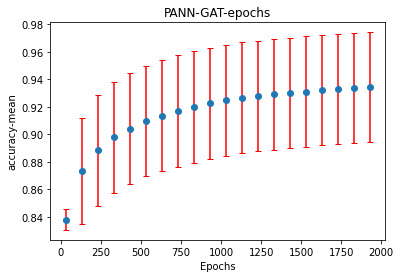

In [ ]:
plt.title('PANN-GAT-epochs')
plt.errorbar(num_epochs_gat, prom_acc_gat,  yerr=dev_values_gat, fmt="o", capsize=3, ecolor="red")
plt.xlabel('Epochs')
plt.ylabel('accuracy-mean')

plt.savefig("PANNs-GAT-epochs.tiff", dpi = 300)

plt.show()

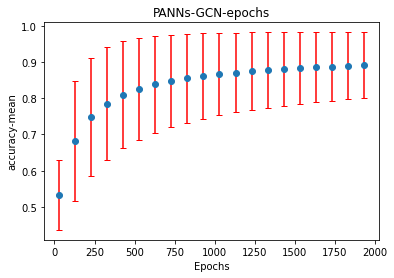

In [ ]:
plt.title('PANNs-GCN-epochs')
plt.errorbar(num_epochs_gcn, prom_acc_gcn,  yerr=dev_values_gcn, fmt="o", capsize=3, ecolor="red")
plt.xlabel('Epochs')
plt.ylabel('accuracy-mean')

plt.savefig("PANNs-GCN-epochs.tiff", dpi = 300)

plt.show()

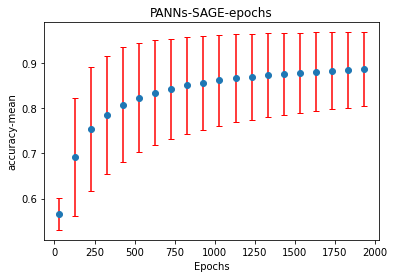

In [ ]:
plt.title('PANNs-SAGE-epochs')
plt.errorbar(num_epochs_sage, prom_acc_sage,  yerr=dev_values_sage, fmt="o", capsize=3, ecolor="red")
plt.xlabel('Epochs')
plt.ylabel('accuracy-mean')

plt.savefig("PANNs-SAGE-epochs.tiff", dpi = 300)

plt.show()

### Prueba variando numero de K vecinos

In [20]:
# GAT

acc_gat = []
K_values_gat = []
prom_acc_gat = []
dev_values_gat = []


#GCN

acc_gcn = []
K_values_gcn = []
prom_acc_gcn = []
dev_values_gcn = []

#SAGE

acc_sage = []
K_values_sage = []
prom_acc_sage = []
dev_values_sage = []

tiempo_graph = []

In [22]:
for j in range(5,101,5):
  test_i = 1
  val_j = 2

  for k in range(10):
      print(f"\n valor de i: {test_i}, valor de j: {val_j}")

      Idx_train, Idx_test, Idx_val = CrossVal(df, test_i, val_j)

      mini = X_tensor[Idx_train].min()
      maxi = X_tensor[Idx_train].max()
      X_tensor_norm = (X_tensor - mini) / (maxi - mini)

      start = time.time()
      data = graph(X_tensor_norm, Y_tensor, Idx_train, Idx_test, Idx_val, j)
      end = time.time()
#==========================GAT===============================================
      
      gat = GAT(2048, 20, 10).to(device)
      train(gat, data, epoch = 50)
      acc_gat.append(test(gat, data, data.test_mask))

#==========================GCN===============================================  

      
      gcn = GCN(2048, 20, 10).to(device).to(device)
      train(gcn, data, epoch = 50)
      acc_gcn.append(test(gcn, data, data.test_mask))

#==========================SAGE=============================================== 

      
      g_sage = GraphSAGE(2048, 20, 10).to(device)
      train(g_sage, data, epoch = 50)
      acc_sage.append(test(g_sage, data, data.test_mask))


      test_i = (test_i + 1)%11
      val_j = (val_j + 1)%11    
      if val_j==0:
        val_j = 1

#==========================GAT===============================================

  K_values_gat.append(j)
  prom_acc_gat.append(np.mean(acc_gat))
  dev_values_gat.append(np.std(acc_gat))
  

#==========================GCN===============================================  

  K_values_gcn.append(j)
  prom_acc_gcn.append(np.mean(acc_gcn))
  dev_values_gcn.append(np.std(acc_gcn))

#==========================SAGE===============================================  

  K_values_sage.append(j)
  prom_acc_sage.append(np.mean(acc_sage))
  dev_values_sage.append(np.std(acc_sage))

  tiempo_graph.append(end - start)

  print(f"GAT\n accuracy mean: {np.mean(acc_gat)*100:.2f}% | standard deviation: {np.std(acc_gat):.2f} | Valor de K: {j}| tiempo: {(end - start):.2f} seg\n"
        f"GCN\n accuracy mean: {np.mean(acc_gcn)*100:.2f}% | standard deviation: {np.std(acc_gcn):.2f} | Valor de K: {j}| tiempo: {(end - start):.2f} seg\n"
        f"SAGE\n accuracy mean: {np.mean(acc_sage)*100:.2f}% | standard deviation: {np.std(acc_sage):.2f} | Valor de K: {j}| tiempo: {(end - start):.2f} seg\n\n"
        f"==============================================================================================================")



 valor de i: 1, valor de j: 2

 valor de i: 2, valor de j: 3

 valor de i: 3, valor de j: 4

 valor de i: 4, valor de j: 5

 valor de i: 5, valor de j: 6

 valor de i: 6, valor de j: 7

 valor de i: 7, valor de j: 8

 valor de i: 8, valor de j: 9

 valor de i: 9, valor de j: 10

 valor de i: 10, valor de j: 1
GAT
 accuracy mean: 78.60% | standard deviation: 0.04 | Valor de K: 5| tiempo: 20.41 seg
GCN
 accuracy mean: 62.87% | standard deviation: 0.06 | Valor de K: 5| tiempo: 20.41 seg
SAGE
 accuracy mean: 61.93% | standard deviation: 0.04 | Valor de K: 5| tiempo: 20.41 seg


 valor de i: 1, valor de j: 2

 valor de i: 2, valor de j: 3

 valor de i: 3, valor de j: 4

 valor de i: 4, valor de j: 5

 valor de i: 5, valor de j: 6

 valor de i: 6, valor de j: 7

 valor de i: 7, valor de j: 8

 valor de i: 8, valor de j: 9

 valor de i: 9, valor de j: 10

 valor de i: 10, valor de j: 1
GAT
 accuracy mean: 78.22% | standard deviation: 0.04 | Valor de K: 10| tiempo: 21.25 seg
GCN
 accuracy mea

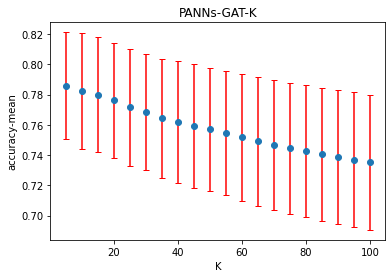

In [23]:
plt.title('PANNs-GAT-K')
plt.errorbar(K_values_gat, prom_acc_gat,  yerr=dev_values_gat, fmt="o", capsize=3, ecolor="red")
plt.xlabel('K')
plt.ylabel('accuracy-mean')

plt.savefig("PANNs_GAT_K.tiff", dpi = 300)

plt.show()

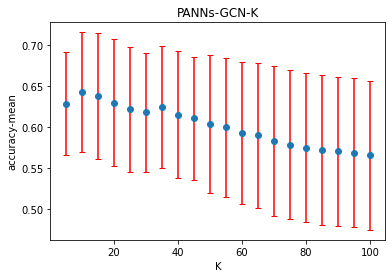

In [24]:
plt.title('PANNs-GCN-K')
plt.errorbar(K_values_gcn, prom_acc_gcn,  yerr=dev_values_gcn, fmt="o", capsize=3, ecolor="red")
plt.xlabel('K')
plt.ylabel('accuracy-mean')

plt.savefig("PANNs_GCN_K.tiff", dpi = 300)

plt.show()

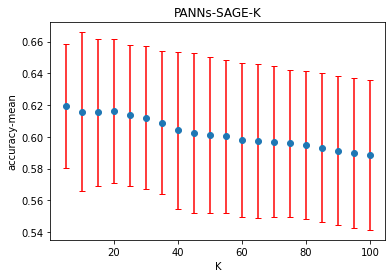

In [25]:
plt.title('PANNs-SAGE-K')
plt.errorbar(K_values_sage, prom_acc_sage,  yerr=dev_values_sage, fmt="o", capsize=3, ecolor="red")
plt.xlabel('K')
plt.ylabel('accuracy-mean')

plt.savefig("PANNs_SAGE_K.tiff", dpi = 300)

plt.show()

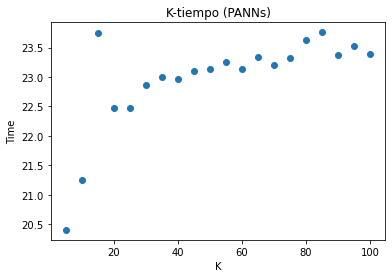

In [26]:
plt.title('K-tiempo (PANNs)')
plt.plot(K_values_gat,tiempo_graph,'o')
plt.xlabel('K')
plt.ylabel('Time')
plt.savefig("PANNs_Tiempo.tiff", dpi = 300)
plt.show()